## <center> Дополнительное профессиональное <br> образование НИУ ВШЭ </center>
#### <center>Программа "Практический анализ данных и машинное обучение" </center>
### <center> Задание выполнила: Ксения Кингсеп </center>

## <center> Индивидуальный проект по анализу данных </center>

**План исследования**
 - Описание набора данных и признаков
 - Первичный анализ признаков
 - Первичный визуальный анализ признаков
 - Закономерности, "инсайты", особенности данных
 - Предобработка данных
 - Построение признаков
 - Отбор признаков
 - Построение модели
 - Кросс-валидация, подбор параметров
 - Кривые валидации и обучения
 - Прогноз для тестовой (или отложенной) выборки
 - Оценка модели с описанием выбранной метрики
 - Выводы

In [2]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, roc_auc_score

### Импорт данных

In [3]:
data = pd.read_csv('credit_train.csv', sep = ';', encoding='cp1251', index_col='client_id')
test = pd.read_csv('credit_test.csv', sep = ';', encoding='cp1251', index_col='client_id')

<img src="TinkoffBank_simple_logo_5.png", width = 100>

###  Часть 1. Описание набора данных и признаков

Данные были взяты из только что прошедшего <a href="https://boosters.pro/champ_3#">соревнования</a> банка Тинькофф. 

#### Постановка задачи

   Tinkoff.ru работает с сетью магазинов электроники, в которой присутствуют и другие банки. Заявка на кредит от покупателя поступает сразу в несколько банков, часть из них заявку одобряют. После этого покупатель выбирает, в каком банке взять кредит. Датасет содержит данные о кредитах на покупку электроники, которые были одобрены Tinkoff.ru. Необходимо предсказать, выберет ли покупатель кредит от Tinkoff.ru.  Файлы `credit_train.csv` и `credit_test.csv` представляет собой набор данных о клиентах, которым был одобрен кредит. Целевой бинарный признак `open_account_flg` содержит `1` если клиент выбрал Тинькофф и `0` в противном случае. 

#### Обзор данных

In [ ]:
data.head().T

In [ ]:
test.head().T

In [ ]:
data.shape

Всего в обучающей выборке 170746 объектов (клиентов) и 14 признаков, в том числе целевой:
- `client_id`: идентификатор клиента (выбран в качестве индекса)
- `gender`: пол клиента (M/F)
- `age`: возраст клиента
- `marital_status`: семейное положение клиента (`UNM` - холост/не замужем, `DIV` - разведен(а), `MAR` - женат/замужем, `WID` - вдовец/вдова, `CIV` - сожительство)
- `job_position`: работа клиента (`SPC` - неруководящий сотрудник - специалист, `DIR` - руководитель организации, `HSK` - домохозяйка, `INV` - не работает (инвалидность), `WOI` - работает на ИП, `WRK` - неруководящих сотрудник - рабочий, `ATP` - неруководящий сотрудник - обслуживающий персонал, `WRP` - работающий пенсионер, `UMN` - руководитель подразделения, `NOR` - не работает, `PNS` - пенсионер, `BIS` - собственный бизнес, `INP` - индивидуальный предприниматель)
- `credit_sum`: сумма кредита
- `credit_month`: срок кредитования в месяцах
- `tariff_id`: номер предлагаемого тарифа
- `score_shk`: неизвестный признак
- `education`: образование клиента (`SCH` - начальное, среднее, `PGR` - второе высшее, `GRD` - высшее, `UGR` - неполное высшее, `ACD` - ученая степень)
- `living_region`: регион проживания
- `monthly_income`: месячный заработок
- `credit_count`: количество кредитов у клиента
- `overdue_credit_count`: количество просроченных кредитов у клиента
- `open_account_flg`: выбрал ли клиент кредит от Тинькофф (целевой признак)


In [ ]:
test.shape

В тестовой выборке содержится 91940 объектов с 13 признаками. 

###  Часть 2. Первичный анализ и предварительная обработка признаков

In [ ]:
data.info()

In [ ]:
test.info()

Несколько признаков являются текстовыми (тип `object`: пол, семейное положение, должность, сумма кредита, образование, регион проживания). Их необходимо будет предобработать и прерватить в бинарные или числовые признаки. Признак `tariff_id`, представленныей количественном виде, потребуется превратить в категориальный, как и йелевой признак `open_account_flg`.

Изменим типы признаков, чтобы в дальнейшем можно было грамотно провести их числовой и визуальный анализ: 

In [4]:
data['tariff_id'] = data['tariff_id'].astype('category')
data['gender'] = data['gender'].astype('category')
data['marital_status'] = data['marital_status'].astype('category')
data['job_position'] = data['job_position'].astype('category')
data['education'] = data['education'].astype('category')
data['open_account_flg'] = data['open_account_flg'].astype('category')
data['score_shk'] = [x.replace(',', '.') for x in data['score_shk']]
data['score_shk'] = data['score_shk'].astype(float)
data['credit_sum'] = [x.replace(',', '.') for x in data['credit_sum']]
data['credit_sum'] = data['credit_sum'].astype(float)

Аналогично трансформируем тестовую выборку. 

In [5]:
test['tariff_id'] = test['tariff_id'].astype('category')
test['gender'] = test['gender'].astype('category')
test['marital_status'] = test['marital_status'].astype('category')
test['job_position'] = test['job_position'].astype('category')
test['education'] = test['education'].astype('category')
test['score_shk'] = [x.replace(',', '.') for x in test['score_shk']]
test['score_shk'] = test['score_shk'].astype(float)
test['credit_sum'] = [x.replace(',', '.') for x in test['credit_sum']]
test['credit_sum'] = test['credit_sum'].astype(float)
test['monthly_income'] = test['monthly_income'].astype(float)

In [ ]:
print(data.info(), test.info())

Все признаки (кроме "сложного" и требующего дополнительной обработки `living_region` теперь имеют правильные типы.   
Посмотрим на *пропуски* в данных:

In [ ]:
data.isnull().sum()

In [ ]:
test.isnull().sum()

Имеются признаки с пропущенными данными (количество кредитов и просроченных кредитов, регион проживания, годовой доход), которые потребуется заполнить. 

Общая статистика по количественным признакам: 

In [ ]:
data.describe()

In [ ]:
test.describe()

На основании этой статистики мы можем составить представление о распределении возрастов (от 18 до 71 года в обеих выборках), сроков кредита (от 3 до 36 месяцев), сумм кредита (от 2736 до 200000 у.е.), ежемесячном доходе клиентов (от 5000 до 950000 у.е. в обучающей выборке и  от 0 до 700000 у.е. в тестовой) и количестве имеющихся (максимум 22) и просроченных (максимум 3) кредитов. 
В целом статистика по обеим выборкам очень близка, скорее всего они взяты из одного распределения. 

Распределение категориальных признаков:

In [ ]:
categorical = ['gender', 'marital_status', 'job_position', 'education', 'tariff_id']
for each_var in categorical:
    print('--------')
    print(each_var)
    print(data[each_var].value_counts())

То же самое для тестовой выборки:

In [ ]:
for each_var in categorical:
    print('--------')
    print(each_var)
    print(test[each_var].value_counts())

Изучим признак `living_region`:

In [ ]:
data['living_region'].nunique(), data['living_region'].unique()

Количество кодировок субъектов Российской Федерации в несколько раз превышает их реальное количество, поэтому для корректного учета данного признака в модели потребуется предобработка данных.

###  Часть 3. Первичный визуальный анализ признаков

Для начала посмотрим на распределение целевого признака:

In [ ]:
sns.countplot(data['open_account_flg']);
data['open_account_flg'].value_counts()

In [ ]:
data['open_account_flg'].value_counts()[1]/(data['open_account_flg'].value_counts()[0] \
                                            +data['open_account_flg'].value_counts()[1])

В представленной выборке 17.6% клиентов выбрали кредит от Tinkoff.ru. 

Построим гистограммы для количественных признаков для обучающей и тестовой выборки:

In [ ]:
figsize(20, 20)
predictors = list(set(data.columns))
plots = data[predictors].hist(bins=20)

In [ ]:
predictors = list(set(test.columns))
plots = test[predictors].hist(bins=20)

Распределения количественных признаков также очень близки для обеих выборок.

Данные по доходам и просроченным кредитам рассмотрим поближе. Сначала посмотрим на гистограмму доходов и их логарифмов:

In [ ]:
fig, axs = plt.subplots(1,2)
figsize(16,8)
data['monthly_income'].hist(bins=100, ax=axs[0]);
data['monthly_income'].apply(np.log).hist(bins=30, ax=axs[1]);

In [ ]:
fig, axs = plt.subplots(1,2)
test['monthly_income'].hist(bins=100, ax=axs[0]);
test['monthly_income'] = test['monthly_income'] + 1
test['monthly_income'].apply(np.log).hist(bins=30, ax=axs[1]);

Большая часть клиентов небольшие зарплаты, однако распределение имеет "правый хвост" с отдельными очень крупными значениями. Распределение логарифма доходов ближе к нормальному.

In [ ]:
data['overdue_credit_count'].value_counts()

In [ ]:
test['overdue_credit_count'].value_counts()

Большая часть клиентов не имеет кредитов, один кредит в обучающей выборке имеет 7326 человек и лишь 55 человек имеют 2-3 кредита. Похожее распределение сохраняется и для тестовой выборки. 

Теперь рассчитаем долю клиентов, выбравших кредит от Тинькофф, для каждого количества просроченных кредитов. 

In [ ]:
ratio_by_od_credit = pd.crosstab(data['overdue_credit_count'], data['open_account_flg'])[1]/ \
(pd.crosstab(data['overdue_credit_count'], data['open_account_flg'])[0] + \
 pd.crosstab(data['overdue_credit_count'], data['open_account_flg'])[1])
figsize(5,5)
sns.barplot(x=ratio_by_od_credit.index, y = ratio_by_od_credit);

Видим тенденцию: клиенты с просроченными кредитами несколько чаще выбирают кредиты от Тинькофф, чем  клиенты без просроченных кредитов. 

Теперь рассчитаем долю клиентов, выбравших кредит от Тинькофф, для людей с разным количеством кредитов.

In [ ]:
ratio_by_credit = pd.crosstab(data['credit_count'], data['open_account_flg'])[1]/ \
(pd.crosstab(data['credit_count'], data['open_account_flg'])[0] + \
 pd.crosstab(data['credit_count'], data['open_account_flg'])[1])

figsize(8, 6)
sns.barplot(x=ratio_by_credit.index, y = ratio_by_credit);

График выше показывает, что доля клиентов, выбравших кредит от Тинькофф имеет тенденцию к возрастаню при увеличении количества имеющихся кредитов. 

Посмотрим, какое влияние оказывает предложенный тариф:

In [ ]:
ratio_by_tariff = pd.crosstab(data['tariff_id'], data['open_account_flg'])[1]/ \
(pd.crosstab(data['tariff_id'], data['open_account_flg'])[0] + \
 pd.crosstab(data['tariff_id'], data['open_account_flg'])[1])
figsize(16, 6)
sns.barplot(x=ratio_by_tariff.index.astype('float64'), y = ratio_by_tariff);

По графику мы видим, что доля клиентов, выбравших кредит от Тинькофф, также сильно изменяется в зависимости от предложенного им тарифа. 
  
Изучим сами тарифы:

In [ ]:
sns.factorplot(data=data, x="tariff_id", y="credit_sum", kind="violin", size = 10);

Можно предположить, что сумма кредита является одной из характеристик для ряда тарифов. 

In [ ]:
sns.factorplot(data=data, x="tariff_id", y="age", kind="violin", size = 10);

Несколько тарифов скорее всего не рассчитаны на покупателей старшей возрастной группы. 

Построим график выбора кредита от Тинькофф в зависимости от срока кредитования:

In [ ]:
ratio_by_len = pd.crosstab(data['credit_month'], data['open_account_flg'])[1]/ \
(pd.crosstab(data['credit_month'], data['open_account_flg'])[0] + \
 pd.crosstab(data['credit_month'], data['open_account_flg'])[1])

figsize(8, 4)
sns.barplot(x=ratio_by_len.index, y = ratio_by_len);

Разброс доли клиентов, выбравших Тинькофф, в зависимости от срока кредитования, довольно большой. 

Попробуем найти иные закономерности в данных. 

In [ ]:
sns.pairplot(data[['age', 'monthly_income', 'credit_sum', 'credit_month', 'score_shk', 'open_account_flg']], hue='open_account_flg');

Отдельно посмотрим на график зарплат и сумм кредита. 

In [ ]:
sns.lmplot(x='monthly_income', y= 'credit_sum', data=data, hue = 'open_account_flg', fit_reg=False, scatter_kws={'alpha': 0.6});

In [ ]:
sns.lmplot(x='monthly_income', y= 'credit_sum', data=test, fit_reg=False, scatter_kws={'alpha': 0.6});

Клиенты, имеющие наиболее высокий доход или наибольшую сумму кредита, выбирают кредиты других банков. Также отметим, что самые крупные кредиты берут покупатели с невысокой и средней зарплатой. Наоборот, покупатели, имеющие высокий доход, берут средние и небольшие кредиты. 

Возраст и сумма кредита:

In [ ]:
sns.lmplot(x='age', y= 'credit_sum', data=data, hue = 'open_account_flg', fit_reg=False);

In [ ]:
sns.lmplot(x='age', y= 'credit_sum', data=test, fit_reg=False);

Самые большие суммы кредитов берут молодые покупатели от 20 до 50 лет. Они чаще отдают предпочтение предложениям других банков. 

Построим матрицу корреляций:

In [ ]:
corr = data[predictors].corr()
figsize(12, 8)
sns.heatmap(corr);

In [ ]:
corr = test[predictors].corr()
figsize(12, 8)
sns.heatmap(corr);

В целом корреляции между количественными призаками довольно слабые. Наиболее сильна корреляция между ежемесячным доходом и суммой кредита (0.35). Как показал график выше, эта зависимость неоднозначна. Коллинеарность признаков не наблюдается. 

Еще несколько любопытных графиков:

In [ ]:
figsize(8,8)
sns.stripplot(x="marital_status", y="monthly_income", data=data, jitter=True);

In [ ]:
sns.stripplot(x="marital_status", y="monthly_income", data=test, jitter=True);

Наиболее высокие доходы характерны для состоящих в браке клиентов. Наиболее низкие в среднем - для вдовцов и состоящих в незарегистрированных отношениях (т.н. "гражданский брак"). В тестовой выборке наблюдаем единичный более высокий доход (500000) для клиентовнескольких групп. 

In [ ]:
sns.stripplot(x="marital_status", y="age", data=data, jitter=True);

Логичная закономерность: среди людей старшей возрастной группы меньше тех, кто состоит в "гражданском браке", а среди вдовцов меньше представителей младщей возрастной групппы. 

In [ ]:
sns.violinplot(x="marital_status", y="credit_sum", hue="gender", data=data, split=True);

In [ ]:
sns.violinplot(x="marital_status", y="credit_sum", hue="gender", data=test, split=True);

In [ ]:
sns.violinplot(x="gender", y="age", hue = "open_account_flg", data=data, split=True);

Отметим, что среди старшей возрастной группы женщин, берущих кредит, больше. Вероятно, это объясняется большей долей женского населения среди пенсионеров в целом. На графике зависимости дохода от должности (ниже) также хорошо выделяется по преобладанию женщин группа пенсионеров. 

In [ ]:
figsize(20,10)
sns.violinplot(x="job_position", y="monthly_income", hue="gender", data=data, split=True);

In [ ]:
sns.jointplot("age", "credit_sum", data=data, kind='kde');

In [ ]:
sns.jointplot("age", "credit_sum", data=test, kind='kde');

График выше демонстрирует, что большая часть покупателей берут в кредит суммы до 25000. Возраст основной массы покупателей - от 25 до 40 лет. 

###  Часть 4. Закономерности, "инсайты", особенности данных

1. Категории большей части признаков были определены неверно, поэтому их требуется изменить, а некоторые - перекодировать для обучения моделей. Наиболее сложной представляется задача приведения к рабочему виду признака `living_region`. 
2. Визуальный анализ данных позволил предположить, что такие признаки как количество кредитов и просроченных кредитов имеют некоторое влияние на выбор клиентов предложения от Тинькофф. Вероятно, это связано с тем, что таким клиентам в целом поступает меньшее количество предложений от других банков. 
3. Клиенты, имеющие наиболее высокий доход и/или большую сумму кредита, предпочитают кредиты других банков. 
4. Тарифы банка предположительно сильно различаются по своим характеристикам, некоторые имеют явную "специализацию" на определенный клиентский сектор. Визуальный анализ показал, что доля клиентов, выбравших Тинькофф существенно различается в зависимости от тарифа. 
5. Скорее всего, исходные данные были грамотно разбиты, обучающая и тестовая выборка были взяты из одного распределения, о чем говорит близое распределение признаков, средние и медианные значения, а также визуальный анализ. 

###  Часть 5. Предобработка данных 

В первую очередь заполним пропуски в данных. Для единственного пропущенного значения ежемесясного дохода возьмем медиану. При отсутствии данных о количестве кредитов и просроченных кредитов будет предполагать, что их нет. 

In [6]:
data['monthly_income'].fillna(value=data['monthly_income'].median(), inplace = True)
data['credit_count'].fillna(0, inplace = True)
data['overdue_credit_count'].fillna(0, inplace = True)

In [7]:
test['monthly_income'].fillna(value=test['monthly_income'].median(), inplace = True)
test['credit_count'].fillna(0, inplace = True)
test['overdue_credit_count'].fillna(0, inplace = True)

Перейдем к перекодированию регионов проживания. Требуется перекодировать повторяющиеся названия краев, областей, республик и автономных округов, а также встречающиеся названия административных центров регионов, муниципальный районов, устаревшие названия и опечатки.

In [8]:
stop = ['РЕСПУБЛИКА', 'ОБЛАСТЬ', 'РЕСП.', 'РЕСП', 'КРАЙ', 'АОБЛ', 'ОБЛ\.', 'ОБЛ', 'АО', 'ЧУВАШИЯ', 'Г\.', '/', '(', ')', 
        'АВТОНОМНАЯ', '\sГ', 'АВТОНОМНЫЙ ОКРУГ - ЮГРА', 'АВТОНОМНЫЙ ОКРУГ - Ю', '- АЛАНИЯ','\.', '\s-', 'ОДИНЦОВО', 'Г\s']
data['clean_region'] = data['living_region']
for word in stop:
    data['clean_region'] = data['clean_region'].str.replace(word, '').str.strip()

In [9]:
data['clean_region'] = data['living_region']
for word in stop:
    data['clean_region'] = data['clean_region'].str.replace(word, '').str.strip()
data['clean_region'].replace(to_replace = 'САХА ЯКУТИЯ', value = 'ЯКУТИЯ', inplace = True)
data['clean_region'].replace(to_replace = 'ОРЁЛ', value = 'ОРЛОВСКАЯ', inplace = True)
data['clean_region'].replace(to_replace = 'ГУСЬ-ХРУСТАЛЬНЫЙ Р-Н', value = 'ВЛАДИМИРСКАЯ', inplace = True)
data['clean_region'].replace(to_replace = 'СЕВ ОСЕТИЯ', value = 'СЕВЕРНАЯ ОСЕТИЯ', inplace = True)
data['clean_region'].replace(to_replace = 'САХА', value = 'ЯКУТИЯ', inplace = True)
data['clean_region'].replace(to_replace = 'ПЕРМСКАЯ', value = 'ПЕРМСКИЙ', inplace = True)
data['clean_region'].replace(to_replace = 'КАМЧАТСКАЯ', value = 'КАМЧАТСКИЙ', inplace = True)
data['clean_region'].replace(to_replace = 'МОСКВОСКАЯ', value = 'МОСКОВСКАЯ', inplace = True)
data['clean_region'].replace(to_replace = 'ЧИТИНСКАЯ', value = 'ЗАБАЙКАЛЬСКИЙ', inplace = True)
data['clean_region'].replace(to_replace = 'ЭВЕНКИЙСКИЙ', value = 'КРАСНОЯРСКИЙ', inplace = True)
data['clean_region'].replace(to_replace = 'МЫТИЩИНСКИЙ Р-Н', value = 'МОСКОВСКАЯ', inplace = True)
data['clean_region'].replace(to_replace = 'БРЯНСКИЙ', value = 'БРЯНСКАЯ', inplace = True)
data['clean_region'].replace(to_replace = 'ГОРЬКОВСКАЯ', value = 'НИЖЕГОРОДСКАЯ', inplace = True)
data['clean_region'].replace(to_replace = '98', value = 'САНКТ-ПЕТЕРБУРГ', inplace = True)
data['clean_region'].replace(to_replace = '74', value = 'ЧЕЛЯБИНСКАЯ', inplace = True)
data['clean_region'].fillna('РОССИЯ', inplace=True)

data['clean_region'].nunique(), data['clean_region'].unique()

(86, array(['КРАСНОДАРСКИЙ', 'МОСКВА', 'САРАТОВСКАЯ', 'ВОЛГОГРАДСКАЯ',
        'ЧЕЛЯБИНСКАЯ', 'СТАВРОПОЛЬСКИЙ', 'НИЖЕГОРОДСКАЯ', 'МОСКОВСКАЯ',
        'ХАНТЫ-МАНСИЙСКИЙ', 'САНКТ-ПЕТЕРБУРГ', 'БАШКОРТОСТАН',
        'АРХАНГЕЛЬСКАЯ', 'ПЕРМСКИЙ', 'КАРАЧАЕВО-ЧЕРКЕССКАЯ', 'КАЛУЖСКАЯ',
        'ВОЛОГОДСКАЯ', 'РОСТОВСКАЯ', 'УДМУРТСКАЯ', 'ИРКУТСКАЯ',
        'ПРИВОЛЖСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ', 'ТЮМЕНСКАЯ', 'БЕЛГОРОДСКАЯ',
        'КОСТРОМСКАЯ', 'ХАКАСИЯ', 'ТАТАРСТАН', 'СВЕРДЛОВСКАЯ', 'ПСКОВСКАЯ',
        'ЗАБАЙКАЛЬСКИЙ', 'ОРЕНБУРГСКАЯ', 'ВОРОНЕЖСКАЯ', 'АСТРАХАНСКАЯ',
        'НОВОСИБИРСКАЯ', 'КУРГАНСКАЯ', 'УЛЬЯНОВСКАЯ', 'МУРМАНСКАЯ',
        'КРАСНОЯРСКИЙ', 'БУРЯТИЯ', 'ЯКУТИЯ', 'АМУРСКАЯ', 'ХАБАРОВСКИЙ',
        'ЯМАЛО-НЕНЕЦКИЙ', 'САМАРСКАЯ', 'ТВЕРСКАЯ', 'ЯРОСЛАВСКАЯ',
        'ВЛАДИМИРСКАЯ', 'ЛЕНИНГРАДСКАЯ', 'ОРЛОВСКАЯ', 'КЕМЕРОВСКАЯ',
        'ОМСКАЯ', 'ЧЕЧЕНСКАЯ', 'КУРСКАЯ', 'ТУЛЬСКАЯ', 'АДЫГЕЯ', 'КОМИ',
        'ПРИМОРСКИЙ', 'СМОЛЕНСКАЯ', 'КИРОВСКАЯ', 'ДАГЕСТАН', 'ПЕНЗЕНСКАЯ',
        'КАРЕЛИЯ

In [10]:
test['clean_region'] = test['living_region']
for word in stop:
    test['clean_region'] = test['clean_region'].str.replace(word, '').str.strip()
test['clean_region'].replace(to_replace = 'САХА ЯКУТИЯ', value = 'ЯКУТИЯ', inplace = True)
test['clean_region'].replace(to_replace = 'ОРЁЛ', value = 'ОРЛОВСКАЯ', inplace = True)
test['clean_region'].replace(to_replace = 'ГУСЬ-ХРУСТАЛЬНЫЙ Р-Н', value = 'ВЛАДИМИРСКАЯ', inplace = True)
test['clean_region'].replace(to_replace = 'СЕВ ОСЕТИЯ', value = 'СЕВЕРНАЯ ОСЕТИЯ', inplace = True)
test['clean_region'].replace(to_replace = 'САХА', value = 'ЯКУТИЯ', inplace = True)
test['clean_region'].replace(to_replace = 'ПЕРМСКАЯ', value = 'ПЕРМСКИЙ', inplace = True)
test['clean_region'].replace(to_replace = ['КАМЧАТСКАЯ', 'КАМЧАТС??ИЙ КРАЙ'], value = 'КАМЧАТСКИЙ', inplace = True)
test['clean_region'].replace(to_replace = 'МОСКВОСКАЯ', value = 'МОСКОВСКАЯ', inplace = True)
test['clean_region'].replace(to_replace = 'ЧИТИНСКАЯ', value = 'ЗАБАЙКАЛЬСКИЙ', inplace = True)
test['clean_region'].replace(to_replace = 'ЭВЕНКИЙСКИЙ', value = 'КРАСНОЯРСКИЙ', inplace = True)
test['clean_region'].replace(to_replace = 'МЫТИЩИНСКИЙ Р-Н', value = 'МОСКОВСКАЯ', inplace = True)
test['clean_region'].replace(to_replace = 'БРЯНСКИЙ', value = 'БРЯНСКАЯ', inplace = True)
test['clean_region'].replace(to_replace = 'ГОРЬКОВСКАЯ', value = 'НИЖЕГОРОДСКАЯ', inplace = True)
test['clean_region'].replace(to_replace = 'ЧУКОТСКИЙ АО', value = 'ЧУКОТСКИЙ', inplace = True)
test['clean_region'].replace(to_replace = 'ЧЕЛЯБИНСК', value = 'ЧЕЛЯБИНСКАЯ', inplace = True)
test['clean_region'].replace(to_replace = 'МОСКОВСКИЙ П', value = 'МОСКВА', inplace = True)
test['clean_region'].replace(to_replace = 'ХАНТЫ-МАНСИЙСКИЙ-ЮГРА', value = 'ХАНТЫ-МАНСИЙСКИЙ', inplace = True)
test['clean_region'].replace(to_replace = 'КАМЧАТС??ИЙ', value = 'КАМЧАТСКИЙ', inplace = True)
test['clean_region'].replace(to_replace = 'ЧУКОТСКИЙ АO', value = 'ЧУКОТСКИЙ', inplace = True)
test['clean_region'].fillna('РОССИЯ', inplace=True)

test['clean_region'].nunique(), data['clean_region'].unique()


(84, array(['КРАСНОДАРСКИЙ', 'МОСКВА', 'САРАТОВСКАЯ', 'ВОЛГОГРАДСКАЯ',
        'ЧЕЛЯБИНСКАЯ', 'СТАВРОПОЛЬСКИЙ', 'НИЖЕГОРОДСКАЯ', 'МОСКОВСКАЯ',
        'ХАНТЫ-МАНСИЙСКИЙ', 'САНКТ-ПЕТЕРБУРГ', 'БАШКОРТОСТАН',
        'АРХАНГЕЛЬСКАЯ', 'ПЕРМСКИЙ', 'КАРАЧАЕВО-ЧЕРКЕССКАЯ', 'КАЛУЖСКАЯ',
        'ВОЛОГОДСКАЯ', 'РОСТОВСКАЯ', 'УДМУРТСКАЯ', 'ИРКУТСКАЯ',
        'ПРИВОЛЖСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ', 'ТЮМЕНСКАЯ', 'БЕЛГОРОДСКАЯ',
        'КОСТРОМСКАЯ', 'ХАКАСИЯ', 'ТАТАРСТАН', 'СВЕРДЛОВСКАЯ', 'ПСКОВСКАЯ',
        'ЗАБАЙКАЛЬСКИЙ', 'ОРЕНБУРГСКАЯ', 'ВОРОНЕЖСКАЯ', 'АСТРАХАНСКАЯ',
        'НОВОСИБИРСКАЯ', 'КУРГАНСКАЯ', 'УЛЬЯНОВСКАЯ', 'МУРМАНСКАЯ',
        'КРАСНОЯРСКИЙ', 'БУРЯТИЯ', 'ЯКУТИЯ', 'АМУРСКАЯ', 'ХАБАРОВСКИЙ',
        'ЯМАЛО-НЕНЕЦКИЙ', 'САМАРСКАЯ', 'ТВЕРСКАЯ', 'ЯРОСЛАВСКАЯ',
        'ВЛАДИМИРСКАЯ', 'ЛЕНИНГРАДСКАЯ', 'ОРЛОВСКАЯ', 'КЕМЕРОВСКАЯ',
        'ОМСКАЯ', 'ЧЕЧЕНСКАЯ', 'КУРСКАЯ', 'ТУЛЬСКАЯ', 'АДЫГЕЯ', 'КОМИ',
        'ПРИМОРСКИЙ', 'СМОЛЕНСКАЯ', 'КИРОВСКАЯ', 'ДАГЕСТАН', 'ПЕНЗЕНСКАЯ',
        'КАРЕЛИЯ

In [11]:
data['clean_region'].value_counts().head(10), data['clean_region'].value_counts().tail(10)

(МОСКОВСКАЯ         12839
 МОСКВА              9261
 КРАСНОДАРСКИЙ       8355
 САНКТ-ПЕТЕРБУРГ     8303
 ТАТАРСТАН           7667
 СВЕРДЛОВСКАЯ        7316
 БАШКОРТОСТАН        6466
 ЧЕЛЯБИНСКАЯ         5155
 САМАРСКАЯ           5104
 СТАВРОПОЛЬСКИЙ      4617
 Name: clean_region, dtype: int64, РОССИЯ                           194
 НЕНЕЦКИЙ                         172
 МАГАДАНСКАЯ                      159
 ДАГЕСТАН                          69
 АЛТАЙ                             54
 ЧУКОТСКИЙ                         32
 ЧЕЧЕНСКАЯ                         31
 ИНГУШЕТИЯ                         19
 ПРИВОЛЖСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ      1
 ДАЛЬНИЙ ВОСТОК                     1
 Name: clean_region, dtype: int64)

In [12]:
test['clean_region'].value_counts().head(10), test['clean_region'].value_counts().tail(10)

(МОСКОВСКАЯ         6840
 МОСКВА             4944
 КРАСНОДАРСКИЙ      4527
 САНКТ-ПЕТЕРБУРГ    4413
 ТАТАРСТАН          4247
 СВЕРДЛОВСКАЯ       3903
 БАШКОРТОСТАН       3328
 САМАРСКАЯ          2859
 ЧЕЛЯБИНСКАЯ        2787
 ИРКУТСКАЯ          2437
 Name: clean_region, dtype: int64, КАЛМЫКИЯ       146
 ЕВРЕЙСКАЯ      124
 РОССИЯ         116
 НЕНЕЦКИЙ        90
 МАГАДАНСКАЯ     82
 ДАГЕСТАН        36
 ЧУКОТСКИЙ       27
 ЧЕЧЕНСКАЯ       25
 АЛТАЙ           24
 ИНГУШЕТИЯ        7
 Name: clean_region, dtype: int64)

Теперь в таблице представлено 83 субъекта РФ (все, существовавшие на момент сбора данных в 2011 году). Для пропущенных значений было выбрано значение `'РОССИЯ'`, уже присутствующее в данных.
Взгляд на топ-10 вверху и внизу таблицы подтверждает ожидания: в регионах с большим количеством населения было зафиксировано больше заявок на получения кредита. Наименьшее количество заявок поступило из регионов с небольшим населением. 
Поскольку признак записан в кириллице, перенумеруем его для дальнейшей работы. 

In [13]:
region_encoder = preprocessing.LabelEncoder()
data['clean_region_enc'] = region_encoder.fit_transform(list(data['clean_region']))
test['clean_region_enc'] = region_encoder.transform(list(test['clean_region']))

In [14]:
data['clean_region_enc'] = data['clean_region_enc'].astype('category')
test['clean_region_enc'] = test['clean_region_enc'].astype('category')

In [15]:
data['clean_region'] = data['clean_region'].astype('category')
test['clean_region'] = test['clean_region'].astype('category')

In [16]:
data.drop('living_region', axis=1, inplace=True)

In [17]:
test.drop('living_region', axis=1, inplace=True)

###  Часть 6. Построение признаков

Идеи новых признаков взяты из докладов победителей контеста на <a href='https://events.yandex.ru/events/mltr/11-mar-2017/'>тренировке по машинному обучению</a>. 

Создадим признак `'fed_reg'`, соответствующий Федеральным округам РФ. 

In [18]:
central = ['Белгородская', 'Брянская', 'Владимирская', 'Воронежская', 
         'Ивановская', 'Калужская', 'Костромская', 'Курская', 'Липецкая', 'Московская', 
           'Орловская', 'Рязанская', 'Смоленская', 'Тамбовская', 'Тверская', 'Тульская', 
           'Ярославская', 'Москва']
central = [x.upper() for x in central]

sev_zap = ['Карелия', 'Коми', 'Архангельская', 'Ненецкий', 'Вологодская', 'Калининградская', 
           'Ленинградская', 'Мурманская', 'Новгородская', 'Псковская', 'Санкт-Петербург']
sev_zap = [x.upper() for x in sev_zap]

yug = ['Адыгея', 'Калмыкия', 'Краснодарский', 'Астраханская', 'Волгоградская', 'Ростовская']
yug = [x.upper() for x in yug]

kavkaz = ['Ставропольский', 'Ингушетия', 'Дагестан', 'Чеченская', 'Кабардино-Балкарская', 
 'Карачаево-Черкесская', 'Северная Осетия']
kavkaz = [x.upper() for x in kavkaz]

volga = ['Башкортостан', 'Марий Эл', 'Мордовия', 'ПРИВОЛЖСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ', 'Татарстан', 
         'Удмуртская', 'Чувашская', 'Кировская', 'Нижегородская', 'Оренбургская', 'Пензенская', 
         'ПЕРМСКИЙ', 'Самарская', 'Саратовская', 'Ульяновская']
volga = [x.upper() for x in volga]

ural = ['Курганская', 'Свердловская', 'Тюменская', 'Челябинская', 'Ханты-Мансийский', 
        'Ямало-Ненецкий']
ural = [x.upper() for x in ural]

sibir = ['Алтай', 'Бурятия', 'Тыва', 'Хакасия', 'Алтайский', 'Забайкальский', 'Красноярский', 
         'Иркутская', 'Кемеровская', 'Новосибирская', 'Омская', 'Томская']
sibir = [x.upper() for x in sibir]

dvostok = ['Якутия', 'камчатский', 'приморский', 'хабаровский', 'амурская', 
           'магаданская', 'сахалинская', 'еврейская', 'чукотский', 'ДАЛЬНИЙ ВОСТОК']
dvostok = [x.upper() for x in dvostok]

russia = ['РОССИЯ']

In [19]:
data['fed_reg'] = 1
test['fed_reg'] = 1
def label_fed_reg(x):
    if x in central:
        return 'central'
    if x in sev_zap:
        return 'sev_zap'
    if x in ural:
        return 'ural'
    if x in yug:
        return 'yug'
    if x in kavkaz:
        return 'kavkaz'
    if x in volga:
        return 'volga'
    if x in sibir:
        return 'sibir'
    if x in dvostok:
        return 'dvostok'
    if x in russia:
        return 'russia'
    else:
        return 'russia'
data['fed_reg'] = data['clean_region'].apply(lambda x: label_fed_reg(x))
test['fed_reg'] = test['clean_region'].apply(lambda x: label_fed_reg(x))

In [20]:
fo_encoder = preprocessing.LabelEncoder()
data['fed_reg_enc'] = fo_encoder.fit_transform(list(data['fed_reg'])).astype('int')
test['fed_reg_enc'] = fo_encoder.transform(list(test['fed_reg'])).astype('int')

Добавим отношение частоты субъекта РФ к частоте федерального округа как признак. 

In [21]:
data['clean_region_freq'] = data.groupby('clean_region')['clean_region'].transform('count')
test['clean_region_freq'] = test.groupby('clean_region')['clean_region'].transform('count')

In [22]:
data['fed_reg_freq'] = data.groupby('fed_reg')['fed_reg'].transform('count')
test['fed_reg_freq'] = test.groupby('fed_reg')['fed_reg'].transform('count')

data['reg_freq_fed_freq'] = data['clean_region_freq']/data['fed_reg_freq']
test['reg_freq_fed_freq'] = test['clean_region_freq']/test['fed_reg_freq']

In [23]:
data.drop(['clean_region_freq', 'fed_reg_freq', 'clean_region', 'fed_reg'], axis=1, inplace=True)
test.drop(['clean_region_freq', 'fed_reg_freq', 'clean_region', 'fed_reg'], axis=1, inplace=True)

Добавим признаки степени округления суммы кредита. 

In [24]:
data['credit_divide10000'] = (data['credit_sum'] % 1000 == 0).astype('int')
test['credit_divide10000'] = (test['credit_sum'] % 1000 == 0).astype('int')

In [25]:
data['credit_kopeyka'] = data['credit_sum'].astype('str').map(lambda x: int(x[-1]))
data['credit_kopeyka'] = (data['credit_kopeyka'] > 0).astype('int')

test['credit_kopeyka'] = test['credit_sum'].astype('str').map(lambda x: int(x[-1]))
test['credit_kopeyka'] = (test['credit_kopeyka'] > 0).astype('int')

In [26]:
test['monthly_income'].replace(0.0, 1.0, inplace=True)

In [27]:
data['overdue_ratio'] = data['overdue_credit_count']/data['credit_count']
data['credit_income_ratio'] = data['credit_sum']/data['monthly_income']
data['monthly_payment'] = data['credit_sum']/data['credit_month']

test['overdue_ratio'] = test['overdue_credit_count']/test['credit_count']
test['credit_income_ratio'] = test['credit_sum']/test['monthly_income']
test['monthly_payment'] = test['credit_sum']/test['credit_month']

In [28]:
data['overdue_ratio'].fillna(0, inplace=True)

In [29]:
test['overdue_ratio'].fillna(0, inplace=True)

Добавим квадраты зарплат, суммы кредита и возраста как признаки. 

In [30]:
data['monthly_income_sq'] = pow(data['monthly_income'], 2)
test['monthly_income_sq'] = pow(test['monthly_income'], 2)

In [31]:
data['age_sq'] = pow(data['age'], 2)
test['age_sq'] = pow(test['age'], 2)

In [32]:
data['credit_sum_sq'] = pow(data['credit_sum'], 2)
test['credit_sum_sq'] = pow(test['credit_sum'], 2)

In [33]:
data.head(2).T

client_id,1,2
gender,M,F
age,48,28
marital_status,MAR,MAR
job_position,UMN,UMN
credit_sum,59998,10889
credit_month,10,6
tariff_id,1.6,1.1
score_shk,0.770249,0.248514
education,GRD,GRD
monthly_income,30000,43000


Категориальные признаки требуется привести к бинарному виду, количественные - нормировать.   
Создадим бинарные признаки:

In [34]:
data_dummies = pd.concat([
                        pd.get_dummies(data.gender, prefix = 'sex'),
                        pd.get_dummies(data.marital_status , prefix = 'marital'),
                        pd.get_dummies(data.job_position, prefix = 'job'),
                        pd.get_dummies(data.tariff_id , prefix = 'tariff'),
                        pd.get_dummies(data.education , prefix = 'educ'),
                        pd.get_dummies(data.fed_reg_enc , prefix = 'fed_reg'),
                        pd.get_dummies(data.clean_region_enc , prefix = 'clean_reg'),
                        data.age,
                        data.age_sq,
                        data.credit_sum,
                        data.credit_sum_sq,
                        data.credit_month,
                        data.score_shk,
                        data.monthly_income,
                        data.monthly_income_sq,
                        data.credit_count,
                        data.overdue_credit_count,   
                        data.monthly_payment,
                        data.credit_income_ratio,
                        data.overdue_ratio,
                        data.credit_kopeyka,
                        data.credit_divide10000,
                        data.reg_freq_fed_freq], axis=1)

In [35]:
data_dummies.head()

,sex_F,sex_M,marital_CIV,marital_DIV,marital_MAR,marital_UNM,marital_WID,job_ATP,job_BIS,job_BIU,...,monthly_income,monthly_income_sq,credit_count,overdue_credit_count,monthly_payment,credit_income_ratio,overdue_ratio,credit_kopeyka,credit_divide10000,reg_freq_fed_freq
client_id,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,1,0,0,0,0,0,...,30000.0,9.000000e+08,1.0,1.0,5999.800000,1.999933,1.0,0,0,0.448663
2,1,0,0,0,1,0,0,0,0,0,...,43000.0,1.849000e+09,2.0,0.0,1814.833333,0.253233,0.0,0,0,0.237188
3,0,1,0,0,1,0,0,0,0,0,...,23000.0,5.290000e+08,5.0,0.0,894.000000,0.466435,0.0,0,0,0.063226
4,1,0,0,1,0,0,0,0,0,0,...,17000.0,2.890000e+08,2.0,0.0,1000.757500,0.706417,0.0,1,0,0.126786
5,0,1,0,0,1,0,0,0,0,0,...,25000.0,6.250000e+08,1.0,0.0,1690.889000,0.676356,0.0,1,0,0.228583


In [36]:
y = data['open_account_flg']

In [37]:
test_dummies = pd.concat([
                        pd.get_dummies(test.gender, prefix = 'sex'),
                        pd.get_dummies(test.marital_status , prefix = 'marital'),
                        pd.get_dummies(test.job_position, prefix = 'job'),
                        pd.get_dummies(test.tariff_id , prefix = 'tariff'),
                        pd.get_dummies(test.education , prefix = 'educ'),
                        pd.get_dummies(test.fed_reg_enc , prefix = 'fed_reg'),
                        pd.get_dummies(test.clean_region_enc , prefix = 'clean_reg'),
                        test.age,
                        test.age_sq,
                        test.credit_sum,
                        test.credit_sum_sq,
                        test.credit_month,
                        test.score_shk,
                        test.monthly_income,
                        test.monthly_income_sq,
                        test.credit_count,
                        test.overdue_credit_count,   
                        test.monthly_payment,
                        test.credit_income_ratio,
                        test.overdue_ratio,
                        test.credit_kopeyka,
                        test.credit_divide10000,
                        test.reg_freq_fed_freq], axis=1)
test_dummies.head()

,sex_F,sex_M,marital_CIV,marital_DIV,marital_MAR,marital_UNM,marital_WID,job_ATP,job_BIS,job_BIU,...,monthly_income,monthly_income_sq,credit_count,overdue_credit_count,monthly_payment,credit_income_ratio,overdue_ratio,credit_kopeyka,credit_divide10000,reg_freq_fed_freq
client_id,,,,,,,,,,,,,,,,,,,,,
170747,1,0,0,0,1,0,0,0,0,0,...,34000.0,1.156000e+09,2.0,0.0,1655.800000,0.487000,0.0,0,0,0.027852
170748,0,1,0,0,1,0,0,0,0,0,...,19000.0,3.610000e+08,3.0,0.0,1171.453333,0.369933,0.0,1,0,0.150815
170749,1,0,0,0,0,1,0,0,0,0,...,25000.0,6.250000e+08,1.0,0.0,1301.900000,0.520760,0.0,0,0,0.017328
170750,1,0,0,0,1,0,0,0,0,0,...,30000.0,9.000000e+08,0.0,0.0,937.900000,0.312633,0.0,0,0,0.240691
170751,1,0,0,0,1,0,0,0,0,0,...,20000.0,4.000000e+08,2.0,0.0,2331.666667,0.699500,0.0,0,0,0.019458


Нормируем числовые признаки:

In [38]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
final_data = scaler.fit_transform(data_dummies)
final_test_data = scaler.fit_transform(test_dummies)

In [39]:
X_train = pd.DataFrame(final_data, columns=data_dummies.columns)
X_test = pd.DataFrame(final_test_data, columns=test_dummies.columns)

In [40]:
X_train.head()

,sex_F,sex_M,marital_CIV,marital_DIV,marital_MAR,marital_UNM,marital_WID,job_ATP,job_BIS,job_BIU,...,monthly_income,monthly_income_sq,credit_count,overdue_credit_count,monthly_payment,credit_income_ratio,overdue_ratio,credit_kopeyka,credit_divide10000,reg_freq_fed_freq
0,-1.039723,1.039723,-0.158725,-0.332198,0.904045,-0.663111,-0.144134,-0.128909,-0.183992,-0.027175,...,-0.404817,-0.187826,-0.554068,4.642515,2.261118,2.677152,10.446563,-0.348282,-0.058734,1.655078
1,0.961794,-0.961794,-0.158725,-0.332198,0.904045,-0.663111,-0.144134,-0.128909,-0.183992,-0.027175,...,0.114268,-0.054636,0.003685,-0.211536,-0.414612,-1.055635,-0.178859,-0.348282,-0.058734,0.257566
2,-1.039723,1.039723,-0.158725,-0.332198,0.904045,-0.663111,-0.144134,-0.128909,-0.183992,-0.027175,...,-0.684324,-0.239895,1.676944,-0.211536,-1.003363,-0.600011,-0.178859,-0.348282,-0.058734,-0.892048
3,0.961794,-0.961794,-0.158725,3.010256,-1.106140,-0.663111,-0.144134,-0.128909,-0.183992,-0.027175,...,-0.923902,-0.273579,0.003685,-0.211536,-0.935106,-0.087157,-0.178859,2.871237,-0.058734,-0.472018
4,-1.039723,1.039723,-0.158725,-0.332198,0.904045,-0.663111,-0.144134,-0.128909,-0.183992,-0.027175,...,-0.604465,-0.226422,-0.554068,-0.211536,-0.493858,-0.151400,-0.178859,2.871237,-0.058734,0.200700


In [41]:
X_test.head()

,sex_F,sex_M,marital_CIV,marital_DIV,marital_MAR,marital_UNM,marital_WID,job_ATP,job_BIS,job_BIU,...,monthly_income,monthly_income_sq,credit_count,overdue_credit_count,monthly_payment,credit_income_ratio,overdue_ratio,credit_kopeyka,credit_divide10000,reg_freq_fed_freq
0,0.963867,-0.963867,-0.160217,-0.335625,0.908596,-0.664893,-0.140629,-0.127205,-0.184795,-0.026186,...,-0.246755,-0.182400,-0.000097,-0.211431,-0.514795,-0.005058,-0.177301,-0.344206,-0.059284,-1.132403
1,-1.037487,1.037487,-0.160217,-0.335625,0.908596,-0.664893,-0.140629,-0.127205,-0.184795,-0.026186,...,-0.855214,-0.319407,0.559822,-0.211431,-0.823712,-0.005850,-0.177301,2.905236,-0.059284,-0.310149
2,0.963867,-0.963867,-0.160217,-0.335625,-1.100599,1.504001,-0.140629,-0.127205,-0.184795,-0.026186,...,-0.611831,-0.273910,-0.560017,-0.211431,-0.740513,-0.004830,-0.177301,-0.344206,-0.059284,-1.202778
3,0.963867,-0.963867,-0.160217,-0.335625,0.908596,-0.664893,-0.140629,-0.127205,-0.184795,-0.026186,...,-0.409011,-0.226518,-1.119937,-0.211431,-0.972673,-0.006238,-0.177301,-0.344206,-0.059284,0.290855
4,0.963867,-0.963867,-0.160217,-0.335625,0.908596,-0.664893,-0.140629,-0.127205,-0.184795,-0.026186,...,-0.814650,-0.312686,-0.000097,-0.211431,-0.083725,-0.003620,-0.177301,-0.344206,-0.059284,-1.188532


###  Часть 7. Отбор признаков

In [42]:
selecting_forest = RandomForestClassifier(n_estimators=1000, max_depth = 5, 
                                      oob_score=True, n_jobs=-1,
                                      random_state=42).fit(X_train, y)

In [43]:
selecting_forest.oob_score_

0.82397245030630295

In [44]:
selecting_forest_predictions = selecting_forest.predict(X_train)
features = pd.DataFrame(selecting_forest.feature_importances_, index=X_train.columns,
                        columns=['Importance']).sort(['Importance'], ascending=False)
pd.set_option('display.max_rows', 100)
features

,Importance
tariff_1.32,2.118334e-01
age_sq,9.050083e-02
age,9.046345e-02
credit_month,6.887851e-02
credit_sum_sq,5.955513e-02
monthly_payment,5.859340e-02
credit_sum,5.555006e-02
educ_GRD,3.949263e-02
job_PNA,3.806426e-02
educ_SCH,3.721726e-02


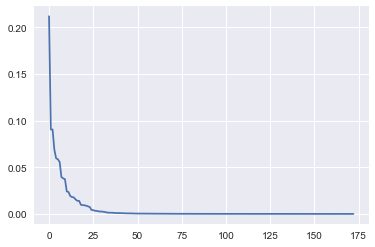

In [45]:
plt.plot(range(len(features.Importance.tolist())), 
         features.Importance.tolist());

In [46]:
least_important = features.index[30:]

In [47]:
X_train_red = X_train.drop(least_important, axis=1)

In [48]:
selecting_forest2 = RandomForestClassifier(n_estimators=1000, max_depth = 5, 
                                      oob_score=True, n_jobs=-1,
                                      random_state=42).fit(X_train_red, y)
selecting_forest2.oob_score_

0.82430042285031568

In [49]:
selecting_forest2_predictions = selecting_forest2.predict(X_train_red)
features2 = pd.DataFrame(selecting_forest2.feature_importances_, index=X_train_red.columns,
                        columns=['Importance']).sort(['Importance'], ascending=False)
pd.set_option('display.max_rows', 100)
features2

,Importance
tariff_1.32,0.278958
credit_month,0.095919
age_sq,0.092393
age,0.091018
credit_sum_sq,0.058872
credit_sum,0.058467
monthly_payment,0.055200
educ_GRD,0.039026
job_PNA,0.037781
tariff_1.1,0.032033


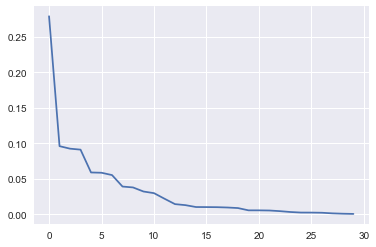

In [50]:
plt.plot(range(len(features2.Importance.tolist())), 
         features2.Importance.tolist());

In [51]:
test_uniques = ['clean_reg_53', 'clean_reg_15', 'tariff_1.96', 'tariff_1.52']
least_important2 = [x for x in list(features.index[30:]) if x not in test_uniques]

In [52]:
X_test_red = X_test.drop(least_important2, axis=1)

In [53]:
X_train_red.to_csv('X_train_red.csv')
X_test_red.to_csv('X_test_red.csv')

In [54]:
y.to_csv('y_train.csv')

###  Часть 8. Построение модели

In [4]:
X_train_red = pd.read_csv('X_train_red.csv', index_col='id')
X_test_red = pd.read_csv('X_test_red.csv', index_col='id')

In [5]:
y = pd.read_csv('y_train.csv', index_col='id')['target']

In [6]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import log_loss
from xgboost import XGBClassifier

In [7]:
classifiers = [LogisticRegression(),
               GradientBoostingClassifier(), 
               RandomForestClassifier(), 
               SVC(),
               SGDClassifier(), 
               XGBClassifier(),
               AdaBoostClassifier()]
classifiers_name = ["LogisticRegression",
               "GradientBoostingClassifier", 
               "RandomForestClassifier", 
               "SVC", "SGDClassifier"]

In [10]:
from sklearn.model_selection import GridSearchCV

scores = []
fits = []
logistic_params = {'penalty': ('l1', 'l2'), 
               'C': (0.01,0.1,1,5)}
gbm_params = { 'n_estimators': [100, 300, 500],
               'learning_rate':(0.1, 0.5, 1),
                'max_depth': list(range(3, 6)), 
               'min_samples_leaf': [10,20,30,40,50]}
forest_params = {'n_estimators': [100, 300, 500],
                'criterion': ('gini', 'entropy'), 
               'max_depth': list(range(3, 10)), 
               'min_samples_leaf': [10,20,30,40,50]}

svm_params = {'kernel' : ('linear', 'rbf'),
              'C': (0.5, 1, 2)           
             }
sgd_params = {'loss': ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'), 
              'penalty': ('l1', 'l2'), 
             }
adb_params = {'n_estimators': (50,100,150)}

xgb_params = {'max_depth': [5,6,7], 
             'n_estimators': [150, 200, 300],
             'learning_rate': [0.1, 0.3, 0.5, 0,7]}

params = [logistic_params, gbm_params, forest_params, svm_params, sgd_params, adb_params]

In [ ]:
# Проводим кросс-валидацию для всех моделей
for i, each_classifier in enumerate(classifiers):
    clf = each_classifier
    clf_params = params[i]
    grid = GridSearchCV(clf, clf_params, 
                        cv=5, 
                        n_jobs=-1, scoring='roc_auc')
    grid.fit(X_train_red, y)
    fits.append(grid.best_params_)
    clf_best_score = grid.best_score_
    scores.append(clf_best_score)
    print(classifiers_name[i], clf_best_score, "\n", grid.best_params_)

In [ ]:
grid_log = GridSearchCV(LogisticRegression(), logistic_params, 
                        cv=5, 
                        n_jobs=-1, scoring='roc_auc', verbose=True)
grid_log.fit(X_train_red, y)
print('Logistic', grid_log.best_score_, "\n", grid_log.best_params_)

In [ ]:
grid_sgd = GridSearchCV(SGDClassifier(), sgd_params, 
                        cv=5, n_jobs=-1, scoring='roc_auc', verbose=True)
grid_sgd.fit(X_train_red, y)
print('SGD', grid_sgd.best_score_, "\n", grid_sgd.best_params_)

In [ ]:
grid_rf = GridSearchCV(RandomForestClassifier(), forest_params, 
                        cv=5, n_jobs=-1, scoring='roc_auc', verbose=True)
grid_rf.fit(X_train_red, y)
print('RF', grid_rf.best_score_, "\n", grid_rf.best_params_)

In [ ]:
grid_svm = GridSearchCV(SVC(), svm_params, 
                        cv=5, n_jobs=-1, scoring='roc_auc', verbose=True)
grid_svm.fit(X_train_red, y)
print('SVM', grid_svm.best_score_, "\n", grid_svm.best_params_)

In [ ]:
grid_gbm = GridSearchCV(GradientBoostingClassifier(), gbm_params, 
                        cv=5, n_jobs=-1, scoring='roc_auc', verbose=True)
grid_gbm.fit(X_train_red, y)
print('GBM', grid_gbm.best_score_, "\n", grid_gbm.best_params_)

In [ ]:
grid_xgb = GridSearchCV(XGBClassifier(), xgb_params, 
                        cv=5, n_jobs=-1, scoring='roc_auc', verbose=True)
grid_xgb.fit(X_train_red, y)
print('XGBoost', grid_xgb.best_score_, "\n", grid_xgb.best_params_)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


In [18]:
xgboost_best = XGBClassifier(learning_rate = 0.1, max_depth = 6, n_estimators = 300)

In [19]:
xgboost_best.fit(X_train_red, y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=300, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [20]:
y_train_xgb = xgboost_best.predict(X_train_red)

In [21]:
roc_auc_score(y, y_train_xgb)

0.57560773801761433

In [61]:
grid_adb = GridSearchCV(AdaBoostClassifier(), adb_params, 
                        cv=5, n_jobs=-1, scoring='roc_auc', verbose=True)
grid_adb.fit(X_train_red, y)
print('AdaBoost', grid_adb.best_score_, "\n", grid_adb.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  5.5min finished


AdaBoost 0.747277704279 
 {'n_estimators': 150}


###  Часть 9. Кросс-валидация, подбор параметров

###  Часть 10. Кривые валидации и обучения

###  Часть 11. Прогноз для тестовой (или отложенной) выборки

In [1]:
y_test_xgb = grid_xgb.predict(X_test_red)
y_test_xgb.to_csv('y_test_xgb.csv')

NameError: name 'grid_xgb' is not defined

###  Часть 12. Оценка модели с описанием выбранной метрики

### Часть 13. Выводы 